# 이웃집 토토치 파이토치 : Day 2
---

<div class="alert alert-info">
    <p>📢 해당 게시물은 파이토치 공식 튜토리얼 중 <a href="https://tutorials.pytorch.kr/beginner/nn_tutorial.htmlhttps://tutorials.pytorch.kr/beginner/nn_tutorial.html">TORCH.NN 이 실제로 무엇인가요?</a>와 <a href="https://tutorials.pytorch.kr/beginner/basics/intro.htmlhttps://tutorials.pytorch.kr/beginner/basics/intro.html">파이토치 기본 익히기</a>를 재구성하여 작성되었습니다.</p>
</div>

#### 주요 키워드
- 신경망 설계 - nn.Module, sequence
- train loop
- optimization
- loss
- dataset, dataloader
- cnn

#### 목차
1. Tensor를 사용한 신경망
    1. 데이터 준비
    2. 신경망 정의
    3. training loop 정의
2. torch.nn.functional 사용하기
    1. torch.nn.functional 사용하기
    2. nn.Module 을 이용하여 리팩토링 하기
    3. nn.Linear 를 이용하여 리팩토링 하기
3. optm을 이용하여 리팩토링 하기
4. fit() 와 get_data() 생성하기
5. CNN 으로 넘어가기
    1. nn.Module
    2. nn.Sequential
    3. DataLoader 감싸기

#### 라이브러리 불러오기

In [1]:
from sklearn.model_selection import train_test_split
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import math


device = torch.device("cpu")
# device = torch.device("cuda") # GPU에서 실행하려면 이 주석을 제거하세요

## 1. Tensor를 사용한 신경망
---

Day1에서는 Tensor와 autograd를 이용하여 신경망을 구성하는 법을 익혔습니다. 해당 부분을 참고하여 아래의 조건을 만족하는 신경망을 구축하여 봅시다.

- FashionMNIST 분류기(입력: 784, 출력: 10)
- 가중치와 편향을 가지는 선형모델
- 활성화 함수 : log softmax
- 손실 함수 : negative log-likelihood)
- 평가 지표 : accuracy
- training loop에서는 아래의 동작을 수행
    - 데이터에서 배치(64)를 선택 👉 DataLoader 사용
    - 모델을 이용하여 예측 수행
    - 손실 계산
    - `backward()`를 이용하여 모델의 기울기 업데이트 👉 weight, bias 업데이트

### A. 데이터 준비

Day1에서 사용되었던 [FashionMNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist) 데이터셋을 다운로드 받아 준비합니다. 다양한 실습을 위하여 이전에는 `TorchVison`에서 불러왔던 것과 달리, 데이터셋을 다운로드 받은 후 이를 직접 정의한 `CustomDataset`으로 읽어들이고자 합니다.

#### a. 데이터 다운로드
데이터를 현재 작업환경 아래의 `data`폴더에 다운로드 받습니다. 이때, `wget` 패키지를 사용하게 되는데 만약 현재 가상환경에 설치 되어 있지 않다면 아래의 pip 코드를 수행시켜 설치를 진행 합니다.

FashionMNIST 데이터셋은 60000개의 학습용 데이터와 100000개의 테스트용 데이터로 구분되어 있습니다. 학습용 데이터 중 10%(6000개)를 validation set으로 분리하도록 합니다.

In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=4498372073e08f1e30d13cdc66d51370a9c80ad739e7e6d1528e899eaadffbd6
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
!mkdir ./data

In [4]:
import wget

urls = ['http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz']

for url in urls:
    # data 폴더 하위에 url에 게재되어 있는 자료를 다운도르 받는다 
    wget.download(url, './data')

In [7]:
# code source : https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
# gz 파일을 열어 이미지와 라벨을 읽어들여 반환해준다.
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
        labels = labels.astype(np.int64)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images/255.0, labels


x_train, y_train = load_mnist('data', kind='train')
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)
x_test, y_test = load_mnist('data', kind='t10k')


print(f'train : image{x_train.shape}/{type(x_train[0])}, label{y_train.shape}/{type(y_train[0])}')
print(f'valid : image{x_val.shape}/{type(x_val[0])}, label{y_val.shape}/{type(y_val[0])}')
print(f'test  : image{x_test.shape}/{type(x_test[0])}, label{y_test.shape}/{type(y_test[0])}')

train : image(54000, 784)/<class 'numpy.ndarray'>, label(54000,)/<class 'numpy.int64'>
valid : image(6000, 784)/<class 'numpy.ndarray'>, label(6000,)/<class 'numpy.int64'>
test  : image(10000, 784)/<class 'numpy.ndarray'>, label(10000,)/<class 'numpy.int64'>


학습 데이터셋 60000과 테스트 데이터셋 10000이 정상적으로 불러와졌습니다.

#### b. 커스텀 데이터셋/데이터로더 정의
커스텀 데이터셋에서는 `__init__`, `__len__`, `__getitem__`을 정의해야 하면 각 메서드에서는 다음과 같은 작업을 수행합니다.

- `__init__` : 클래스의 멤버변수 x, y, transform, target_transform을 파라미터를 이용하여 초기화 합니다. 이때, x는 image 데이터/y는 라벨/transform은 이미지에 적용 될 transform/target_transform은 라벨에 적용 될 transform을 의미합니다.
- `__len__` : 데이터셋의 샘플 개수를 반환합니다.
- `__getitem__` : 주어진 인덱스에 해당하는 샘플을 (image, label) 쌍으로 반환합니다. 이때, image에는 transform을 적용하고 라벨에는 target_transform을 적용하여 반환합니다.

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, x, y, transform=None, target_transform=None):
        self.labels = ["T-Shirt",  "Trouser", "Pullover", "Dress", "Coat", 
                       "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
        
        self.x = x # 이미지
        self.y = y # 라벨
        self.transform = transform # 이미지에 적용 될 transform
        self.target_transform = target_transform # 라벨에 적용 될 transform

    def __len__(self):
        return len(self.y) # 데이터셋의 샘플 개수

    def __getitem__(self, idx): # 주어진 idx번째에 해당하는 샘플을 반환
        img = self.x[idx]
        label = self.y[idx]
        
        if self.transform:
            image = self.transform(img)
        
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

training loop에서는 배치를 선택하는 구간이 존재합니다. 이를 수월하기 진행하기 위하여 위에서 `DataLoader`를 이용하려고 합니다. DataLoader가 어떤 기능을 하는지 가물가물 하시다면 아래의 설명을 확인해 보세요.

<details>
    <summary>DataLoader</summary>
    <div markdown="1">       
      `DataLoader` 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있습니다. 아래의 각 순회(iteration)는 (각각 `batch_size=64` 의 특징(feature)과 정답(label)을 포함하는) `train_features` 와 `train_labels` 의 묶음(batch)을 반환합니다. `shuffle=True` 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞입니다.
(데이터 불러오기 순서를 보다 세밀하게(finer-grained) 제어하려면 <a href="https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler" >Samplers</a>
를 살펴보세요.)
    </div>
</details>

In [9]:
train_ds = CustomImageDataset(x_train, y_train, 
                              transform=torch.Tensor)
val_ds = CustomImageDataset(x_val, y_val, 
                            transform=torch.Tensor)

x_test = torch.Tensor(x_test).to(device)
y_test = torch.from_numpy(y_test).to(device)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

train_dl, val_dl

(<torch.utils.data.dataloader.DataLoader at 0x7fa61dee4090>,
 <torch.utils.data.dataloader.DataLoader at 0x7fa61dee45d0>)

데이터 로더가 정상적으로 생성되었는지 배치 하나를 출력하여 확인해 봅시다.

In [10]:
def get_label_name(label): # 라벨(숫자)를 입력받아 해당 라벨의 의미를 반환
    LABLE_NAMES = ["T-Shirt",  "Trouser", "Pullover", "Dress", "Coat", 
                   "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
    return LABLE_NAMES[label]

In [11]:
def show_batch(features, labels):
    fig = plt.figure(figsize=(10, 10))

    for i in range(1, 65):
        img = features[i-1]
        label = get_label_name(labels[i-1])
        ax = fig.add_subplot(8, 8, i)
        
        
        if device.type  == "cuda":
            img = img.cpu()
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(label)
        ax.set_xticks([]), ax.set_yticks([])

    plt.tight_layout()
    plt.show()

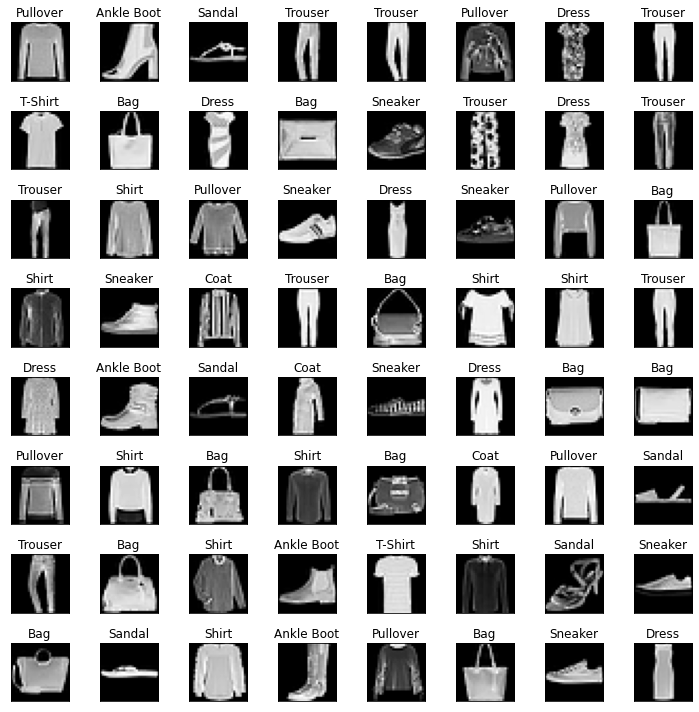

In [12]:
features, labels = next(iter(train_dl))
features, labels = features.to(device), labels.to(device)
show_batch(features, labels)

<div class="alert alert-warning">
    <p><b>Q. `get_label_name(np.argmax(labels[i-1]))`는 인코딩 되어 있는 라벨값을 라벨의 이름으로 변환합니다. 여기서 argmax 함수가 하는 역할을 무엇인가요?</b></p>
    <p>👉 (여기에 답을 입력해 주세요)</p>
</div>

### B. 신경망 정의

#### a. 가중치 정의

PyTorch는 랜덤 또는 0으로만 이루어진 텐서를 생성하는 메서드를 제공하고, 우리는 간단한 선형 모델의 가중치(weights)와 절편(bias)을 생성하기 위해서 이것을 사용할 것입니다. 이들은 일반적인 텐서에 매우 특별한 한 가지가 추가된 것입니다.

우리는 PyTorch에게 이들이 기울기(gradient)가 필요하다고 알려줍니다.
이를 통해 PyTorch는 텐서에 행해지는 모든 연산을 기록하게 하고,
따라서 *자동적으로* 역전파(back-propagation) 동안에 기울기를 계산할 수 있습니다!

가중치에 대해서는 `requires_grad_` 를 초기화(initialization) **다음에** 설정합니다,
왜냐하면 우리는 해당 단계가 기울기에 포함되는 것을 원치 않기 때문입니다.
(PyTorch에서 `_` 다음에 오는 메서드 이름은 연산이 인플레이스(in-place)로 수행되는 것을 의미합니다.)

<div class="alert alert-info"><b>📌 Note</b><p><a href="http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf"><u>Xavier initialisation</u></a> 
   기법을 이용하여 가중치를 초기화 합니다. Standard gaussian을 이용해 생성한 난수를 '입력의 수'로 나누어 스케일링 합니다. 이에 대해서는 cs231n lec6에서 다뤄지고 있으니 한번 살펴보시기 바랍니다.</p></div>

In [13]:
weights = torch.randn(784, 10, device=device) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, device=device, requires_grad=True)
weights, bias

(tensor([[ 0.0039, -0.0620,  0.0229,  ..., -0.0476,  0.0183,  0.0208],
         [-0.0365, -0.0128, -0.0647,  ...,  0.0219, -0.0143, -0.0458],
         [ 0.0333, -0.0532, -0.0157,  ...,  0.0254, -0.0225,  0.0340],
         ...,
         [-0.0293, -0.0134,  0.0408,  ..., -0.0120, -0.0219, -0.0082],
         [ 0.0041, -0.0303, -0.0145,  ...,  0.0005, -0.0127,  0.0347],
         [ 0.0425, -0.0199,  0.0063,  ...,  0.0534, -0.0333, -0.0147]],
        requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

<div class="alert alert-warning">
    <p><b>Q. 위에서 정의한 가중치의 형상은 (784x10) 입니다. 왜 이렇게 정의되었을까요?</b></p>
    <p>👉 입력 이미지의 크기가 784(28x28x1) 이고, 분류해야 할 label의 class가 10개이다.  </p>
</div>

#### b. 모델 정의

PyTorch의 기울기를 자동으로 계산해주는 기능 덕분에, Python 표준 함수
(또는 호출 가능한 객체)를 모델로 사용할 수 있습니다!
그러므로 간단한 선형 모델을 만들기 위해서 단순한 행렬 곱셈과 브로드캐스트(broadcast) 덧셈을 사용하여 보겠습니다.

또한, 우리는 활성화 함수(activation function)가 필요하므로,`log_softmax` 를 구현하고 사용할 것입니다. PyTorch에서 많은 사전 구현된 손실 함수(loss function), 활성화 함수들이 제공되지만, 일반적인 python을 사용하여 자신만의 함수를 쉽게 작성할 수 있음을 기억해주세요.

PyTorch는 심지어 여러분의 함수를 위해서 빠른 GPU 또는 벡터화된 CPU 코드를 만들어줄 것입니다.

In [14]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

<details>
    <summary>log_softmax의 정의가 왜 저렇게 되지?-하는 의문에 생긴다면 아래의 링크들을 확인해 보세요.</summary>
    <div markdown="1">       
        • <a href="https://forums.fast.ai/t/what-is-torch-nn-really/36206/6">What is torch.nn really?</a><br>
        • <a href="https://discuss.pytorch.org/t/log-softmax-function-in-pytorch-tutorial-example/52041">“log_softmax function” in pytorch tutorial example</a>
    </div>
</details>

위에서, `@` 기호는 점곱(dot product) 연산을 나타냅니다.
우리는 하나의 배치(batch) 데이터(이 경우에는 64개의 이미지들)에 대하여 함수를 호출할 것입니다.
이것은 하나의 *포워드 전달(forward pass)* 입니다. 이 단계에서 우리는 무작위(random) 가중치로
시작했기 때문에 우리의 예측이 무작위 예측보다 전혀 나은 점이 없을 것입니다.

In [15]:
preds = model(features)  # 예측
print(f'preds[0] : {preds[0]}\npreds.shape : {preds.shape}')

preds[0] : tensor([-1.8791, -2.1572, -2.4975, -2.5766, -1.8554, -2.4115, -2.3357, -2.2625,
        -4.2105, -2.1932], grad_fn=<SelectBackward>)
preds.shape : torch.Size([64, 10])


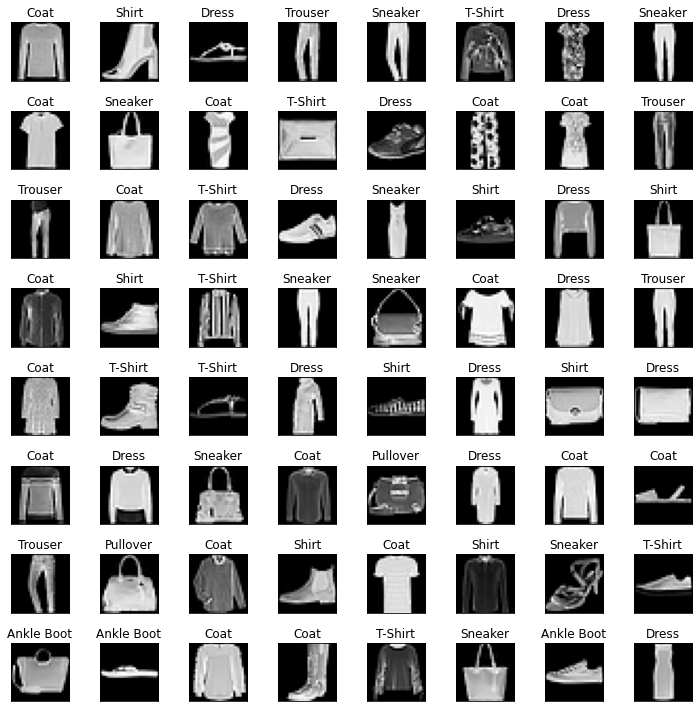

In [16]:
preds_label = torch.argmax(preds, -1)
show_batch(features, preds_label)

#### c. loss

여러분이 보시듯이, ``preds`` 텐서(tensor)는 텐서 값 외에도, 또한
기울기 함수(gradient function)를 담고 있습니다.
우리는 나중에 이것을 역전파(backpropagation)를 위해 사용할 것입니다.
이제 손실함수(loss function)로 사용하기 위한 `음의 로그 우도(negative log-likelihood)`를
구현합시다. (다시 말하지만, 우리는 표준 Python을 사용할 수 있습니다.)

![](https://i.ibb.co/5WNgh0n/hU252jE.jpg)<br>
[이미지 출처 : https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/ ]

In [17]:
def nll(pred, target):
    return -pred[range(target.shape[0]), target].mean()

loss_func = nll

<div class="alert alert-warning">
    <p><b>Q. 위에서 정의한 nll의 동작 방식을 설명하여 주세요.</b></p>
    <p>👉 (여기에 답을 입력해 주세요)</p>
</div>

우리의 무작위 모델에 대한 손실을 점검해봅시다, 그럼으로써 우리는 나중에 역전파 이후에 개선이 있는지 확인할 수 있습니다.

In [18]:
yb =labels
print(loss_func(preds, yb))

tensor(2.5135, grad_fn=<NegBackward>)


#### d. accuracy

우리 모델의 정확도(accuracy)를 계산하기 위한 함수를 구현합시다. 매 예측마다, 만약 가장 큰 값의 인덱스가 목표값(target value)과 동일하다면, 그 예측은 올바른 것입니다.

In [19]:
def accuracy(out, yb): # yb: y batch
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

우리의 무작위 모델의 정확도를 점검해 봅시다, 그럼으로써 손실이 개선됨에 따라서 정확도가 개선되는지 확인할 수 있습니다.

In [20]:
print(accuracy(preds, yb))

tensor(0.1406)


### C. training loop(훈련 루프) 정의

이제 우리는 훈련 루프(training loop)를 실행할 수 있습니다. 매 반복마다, 우리는 다음을 수행할 것입니다:

- 데이터의 미니배치를 선택
- 모델을 이용하여 예측 수행
- 손실 계산
- ``loss.backward()`` 를 이용하여 모델의 기울기 업데이트, 이 경우에는, ``weights`` 와 ``bias``.

이제 우리는 이 기울기들을 이용하여 가중치와 절편을 업데이트 합니다.
우리는 이것을 ``torch.no_grad()`` 컨텍스트 매니져(context manager) 내에서 실행합니다,
왜냐하면 이러한 실행이 다음 기울기의 계산에 기록되지 않기를 원하기 때문입니다.
PyTorch의 자동 기울기(Autograd)가 어떻게 연산을 기록하는지
[여기](https://pytorch.org/docs/stable/notes/autograd.html)에서 더 알아볼 수 있습니다.

우리는 그러고나서 기울기를 0으로 설정합니다, 그럼으로써 다음 루프(loop)에 준비하게 됩니다.
그렇지 않으면, 우리의 기울기들은 일어난 모든 연산의 누적 집계를 기록하게 되버립니다.
(즉, ``loss.backward()`` 가 이미 저장된 것을 대체하기보단, 기존 값에 기울기를 *더하게* 됩니다).

<div class="alert alert-info"><b>📌 Tip</b><p>여러분들은 PyTorch 코드에 대하여 표준 python 디버거(debugger)를 사용할 수 있으므로, 매 단계마다 다양한 변수 값을 점검할 수 있습니다. 아래에서  `set_trace()` 를 주석 해제하여 사용해보세요.</div>

In [21]:
from IPython.core.debugger import set_trace

print(f'[before] loss : {loss_func(model(x_test), y_test)}')
print(f'[before] acc : {accuracy(model(x_test), y_test)}')

lr = 0.5  # 학습률(learning rate)
epochs = 2  # 훈련에 사용할 에폭(epoch) 수

for epoch in range(epochs):
    for xb, yb in train_dl:
#         set_trace()
        xb = xb.to(device)
        yb = yb.to(device)
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
            

    # validation
    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for xb, yb in val_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            val_loss += loss_func(model(xb), yb)
            val_acc += accuracy(model(xb), yb)
            
    print(f'epoch {epoch+1} >>> val loss({val_loss / len(val_dl):.7f}), acc({val_acc / len(val_dl):.7f})')
            
print(f'[after ] loss : {loss_func(model(x_test), y_test)}')
print(f'[after ] acc : {accuracy(model(x_test), y_test)}')

[before] loss : 2.4122917652130127
[before] acc : 0.11330000311136246
epoch 1 >>> val loss(1.2395082), acc(0.7801419)
epoch 2 >>> val loss(3.0222616), acc(0.6631206)
[after ] loss : 2.9264214038848877
[after ] acc : 0.6674000024795532


지난 시간 기울기를 0으로 설정해 주어야하는 이유에 대하여 집고 넘어가지 않아 아래의 내용을 추가하였습니다. 코드는 sin 함수를 예측하는 신경망이고, 학습 과정에서 기울기를 0으로 설정하였을 때와 그렇지 않을 경우의 local gradient의 변화를 출력하고 있습니다. 코드와 실행결과를 보고 아래의 질문에 답해주세요.

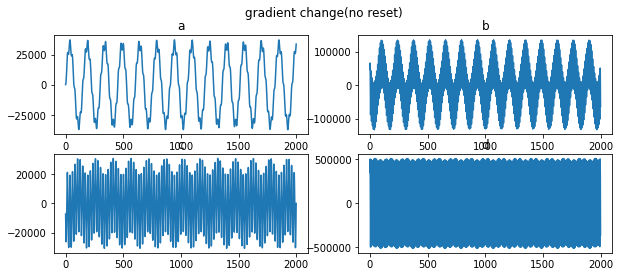

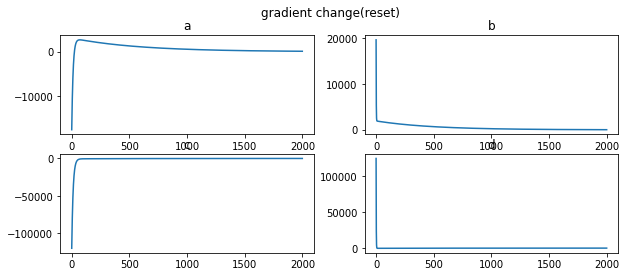

In [22]:
import torch
import math

def get_grad_hist(mode):
    dtype = torch.float

    x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
    y = torch.sin(x)

    a = torch.randn((), device=device, dtype=dtype, requires_grad=True)
    b = torch.randn((), device=device, dtype=dtype, requires_grad=True)
    c = torch.randn((), device=device, dtype=dtype, requires_grad=True)
    d = torch.randn((), device=device, dtype=dtype, requires_grad=True)

    grad_log = [[], [], [], []]

    learning_rate = 1e-6
    for t in range(2000):
        y_pred = a + b * x + c * x ** 2 + d * x ** 3
        loss = (y_pred - y).pow(2).sum()

        loss.backward()
        with torch.no_grad():
            a -= learning_rate * a.grad
            b -= learning_rate * b.grad
            c -= learning_rate * c.grad
            d -= learning_rate * d.grad

            grad_log[0].append(float(a.grad))
            grad_log[1].append(float(b.grad))
            grad_log[2].append(float(c.grad))
            grad_log[3].append(float(d.grad))

            if mode == 1:
                # 가중치 갱신 후에는 변화도를 직접 0으로 만듭니다.
                a.grad = None
                b.grad = None
                c.grad = None
                d.grad = None
                
    return grad_log

def show_grad(grad_log, title):
    fig = plt.figure(figsize=(10, 4))

    label = ['a', 'b', 'c', 'd']
    for i in range(1, 5):
        ax = fig.add_subplot(2, 2, i)
        ax.plot(range(2000), grad_log[i-1], label=label[i-1])
        ax.set_title(label[i-1])
   
    fig.suptitle(title)
    plt.show()

grad_log_with_reset_gradient = get_grad_hist(1)
grad_log_with_acc_gradient = get_grad_hist(0)

show_grad(grad_log_with_acc_gradient, 'gradient change(no reset)')
show_grad(grad_log_with_reset_gradient, 'gradient change(reset)')

<div class="alert alert-warning">
    <p><b>Q. 위 코드의 실행결과에서 두 plot는 확연한 차이를 보입니다. 이런한 차이를 보이는 이유는 무엇이고 어떤 plot가 잘 학습되고 있는 모델의 plot일까요?</b>  <a href="https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch">tip</a></p>
    <p>👉 Pytorch에서 기울기를 0으로 설정 해주는 이유는 역전파 단계에서 gradient 값들을 계속 누적해서 합산해주기 때문이다. </p>
</div>

## 2. torch.nn을 이용한 리팩토링
---

이제 우리는 코드를 리팩토링(refactoring) 하겠습니다, 그럼으로써 이전과 동일하지만,
PyTorch의 ``nn`` 클래스의 장점을 활용하여 더 간결하고 유연하게 만들 것입니다.
지금부터 매 단계에서, 우리는 코드를 더 짧고, 이해하기 쉽고, 유연하게 만들어야 합니다.

### A. torch.nn.functional 사용하기

처음이면서 우리의 코드를 짧게 만들기 가장 쉬운 단계는 직접 작성한 <u>활성화, 손실 함수</u>를 ``torch.nn.functional`` 의 함수로 대체하는 것입니다(관례에 따라, 일반적으로 ``F`` 네임스페이스(namespace)를 통해 임포트(import) 합니다).

In [23]:
import torch.nn.functional as F

이 모듈에는 ``torch.nn`` 라이브러리의 모든 함수가 포함되어 있습니다(라이브러리의 다른 부분에는 클래스가 포함되어 있습니다.) 
다양한 손실 및 활성화 함수 뿐만 아니라, 풀링(pooling) 함수와 같이 신경망을 만드는데 편리한 몇 가지 함수도 여기에서 찾을 수 있습니다.(컨볼루션(convolution) 연산, 선형(linear) 레이어, 등을 수행하는 함수도 있지만, 앞으로 보시겠지만 일반적으로 라이브러리의 다른 부분을 사용하여 더 잘 처리 할 수 있습니다.)

만약 여러분들이 음의 로그 우도 손실(nll)과 로그 소프트맥스(log softmax) 활성화 함수를 사용하는 경우, Pytorch는 이 둘을 결합하는 단일 함수인 `F.cross_entropy`를 제공합니다. 

따라서 모델에서 활성화 함수를 제거할 수도 있습니다.
- [[Pytorch] softmax와 log_softmax (그리고 CrossEntropyLoss)](https://junstar92.tistory.com/118)
- [03. 소프트맥스 회귀의 비용 함수 구현하기](https://wikidocs.net/60572)

In [24]:
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

더이상 ``model`` 함수에서 ``log_softmax`` 를 호출하지 않고 있습니다.
손실과 정확도과 이전과 동일한지 확인해봅시다.

In [25]:
print(loss_func(model(x_test), y_test), accuracy(model(x_test), y_test))

tensor(2.9264, grad_fn=<NllLossBackward>) tensor(0.6674)


### B. nn.Module 을 이용하여 리팩토링 하기

다음으로, 더 명확하고 간결한 훈련 루프를 위해 ``nn.Module`` 및 ``nn.Parameter`` 를 사용합니다.
우리는 ``nn.Module`` (자체가 클래스이고 상태를 추척할 수 있는) 하위 클래스(subclass)를 만듭니다.
이 경우에는, 포워드(forward) 단계에 대한 가중치, 절편, 그리고 메소드(method) 등을 유지하는
클래스를 만들고자 합니다.
``nn.Module`` 은 우리가 사용할 몇 가지 속성(attribute)과 메소드를 (``.parameters()`` 와
``.zero_grad()`` 같은) 가지고 있습니다.

<div class="alert alert-info"><b>📌 Note</b><p>`nn.Module`은 PyTorch 의 특정 개념이고, 우리는 이 클래스를 많이 사용할 것입니다. `nn.Module`를 Python의 코드를 임포트하기 위한 코드 파일인 <a href="https://docs.python.org/3/tutorial/modules.html">module</a>의 개념과 헷갈리지 말아주세요.</div>

In [26]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

함수를 사용하는 대신에 이제는 오브젝트(object) 를 사용하기 때문에,
먼저 모델을 인스턴스화(instantiate) 해야 합니다.

In [27]:
model = Mnist_Logistic()
model.to(device)

Mnist_Logistic()

이제 우리는 이전과 동일한 방식으로 손실을 계산할 수 있습니다.
여기서 ``nn.Module`` 오브젝트들은 마치 함수처럼 사용됩니다 (즉, 이들은 *호출가능* 합니다),
그러나 배후에서 Pytorch 는 우리의 ``forward`` 메소드를 자동으로 호출합니다.

In [28]:
print(loss_func(model(x_test), y_test), accuracy(model(x_test), y_test))

tensor(2.4968, grad_fn=<NllLossBackward>) tensor(0.1444)


이전에는 훈련 루프를 위해 이름 별로 각 매개변수(parameter)의 값을 업데이트하고 다음과 같이
각 매개 변수에 대한 기울기들을 개별적으로 수동으로 0으로 제거해야 했습니다.

```python
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()
```

이제 우리는 model.parameters() 및 model.zero_grad() (모두 ``nn.Module`` 에 대해 PyTorch에 의해 정의됨)를 활용하여 이러한 단계를 더 간결하게 만들고, 특히 더 복잡한 모델에 대해서 일부 매개변수를 잊어 버리는 오류를 덜 발생시킬 수 있습니다.

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
        model.zero_grad()
```

이제 이것을 나중에 다시 실행할 수 있도록 ``fit`` 함수로 작은 훈련 루프를 감쌀 것입니다.

훈련 전에 항상 `model.train()`을 호출하고, 추론(inference) 전에 `model.eval()`을 호출합니다, 이는 `nn.BatchNorm2d` 및 `nn.Dropout`과 같은 레이어에서 이러한 다른 단계(훈련, 추론) 에 대한 적절한 동작이 일어나게 하기 위함입니다.)

In [29]:
def fit(model, train_dl, val_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

        model.eval()
        with torch.no_grad():
            val_loss, val_acc = 0, 0
            for xb, yb in val_dl:
                xb = xb.to(device)
                yb = yb.to(device)
                val_loss += loss_func(model(xb), yb)
                val_acc += accuracy(model(xb), yb)

            print(f'epoch {epoch+1} >>> val loss({val_loss / len(val_dl):.7f}), acc({val_acc / len(val_dl):.7f})')


print(f'[before] loss : {loss_func(model(x_test), y_test)}')
print(f'[before] acc : {accuracy(model(x_test), y_test)}')

lr = 0.5  # 학습률(learning rate)
epochs = 2  # 훈련에 사용할 에폭(epoch) 수
fit(model, train_dl, val_dl)

print(f'[after ] loss : {loss_func(model(x_test), y_test)}')
print(f'[after ] acc : {accuracy(model(x_test), y_test)}')

[before] loss : 2.496812582015991
[before] acc : 0.1444000005722046
epoch 1 >>> val loss(1.2414318), acc(0.7686170)
epoch 2 >>> val loss(0.9077050), acc(0.7928857)
[after ] loss : 0.912898063659668
[after ] acc : 0.7943999767303467


### C. nn.Linear 를 이용하여 리팩토링 하기

계속해서 코드를 리팩토링 합니다. `self.weights` 및 `self.bias`를 수동으로 정의 및 초기화하고, `xb  @ self.weights + self.bias`를 계산하는 대신에, 위의 모든 것을 해줄 Pytorch 클래스인 [nn.Linear](https://pytorch.org/docs/stable/nn.html#linear-layers)를 선형 레이어로 사용합니다.

Pytorch에는 다양한 유형의 코드를 크게 단순화 할 수 있는 미리 정의된 레이어가 있고 이는 또한 종종 기존 코드보다 속도를 빠르게 합니다.

In [30]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

이전과 같은 방식으로 모델을 인스턴스화하고 손실을 계산합니다:

In [32]:
model = Mnist_Logistic().to(device)
print(loss_func(model(x_test), y_test), accuracy(model(x_test), y_test))

tensor(2.2715, grad_fn=<NllLossBackward>) tensor(0.1118)


우리는 여전히 이전과 동일한 `fit` 메소드를 사용할 수 있습니다.

In [33]:
print(f'[before] loss : {loss_func(model(x_test), y_test)}')
print(f'[before] acc : {accuracy(model(x_test), y_test)}')

lr = 0.5  # 학습률(learning rate)
epochs = 2  # 훈련에 사용할 에폭(epoch) 수
fit(model, train_dl, val_dl)

print(f'[after ] loss : {loss_func(model(x_test), y_test)}')
print(f'[after ] acc : {accuracy(model(x_test), y_test)}')

[before] loss : 2.2715487480163574
[before] acc : 0.11180000007152557
epoch 1 >>> val loss(0.7135529), acc(0.8106161)
epoch 2 >>> val loss(1.5354000), acc(0.7681738)
[after ] loss : 1.5562034845352173
[after ] acc : 0.76910001039505


## 3. optm을 이용하여 리팩토링 하기
---

Pytorch에는 다양한 최적화(optimization) 알고리즘을 가진 패키지인 `torch.optim`도 있습니다.
각 매개변수를 수동으로 업데이트 하는 대신, 옵티마이저(optimizer)의 `step` 메소드를 사용하여
업데이트를 진행할 수 있습니다.

이렇게 하면 이전에 수동으로 코딩한 최적화 단계를 대체할 수 있습니다:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

대신에 이렇게 말이죠:
```python
opt.step()
opt.zero_grad()
```

(`optim.zero_grad()` 는 기울기를 0으로 재설정 해줍니다. 다음 미니 배치에 대한 기울기를 계산하기 전에 호출해야 합니다.)


In [34]:
from torch import optim

나중에 다시 사용할 수 있도록 모델과 옵티마이져를 만드는 작은 함수를 정의합니다.

In [35]:
def get_model():
    model = Mnist_Logistic().to(device)
    return model, optim.SGD(model.parameters(), lr=lr)

In [36]:
model, opt = get_model()

print(f'[before] loss : {loss_func(model(x_test), y_test)}')
print(f'[before] acc : {accuracy(model(x_test), y_test)}')

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

    model.eval()
    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for xb, yb in val_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            val_loss += loss_func(model(xb), yb)
            val_acc += accuracy(model(xb), yb)

    print(f'epoch {epoch+1} >>> val loss({val_loss / len(val_dl):.7f}), acc({val_acc / len(val_dl):.7f})')
        
print(f'[after ] loss : {loss_func(model(x_test), y_test)}')
print(f'[after ] acc : {accuracy(model(x_test), y_test)}')

[before] loss : 2.3523008823394775
[before] acc : 0.07840000092983246
epoch 1 >>> val loss(0.9427791), acc(0.7974291)
epoch 2 >>> val loss(0.8941372), acc(0.7999778)
[after ] loss : 0.9414258003234863
[after ] acc : 0.791100025177002


## 4. fit() 와 get_data() 생성하기
---

이제 우리는 우리만의 작은 리팩토링을 수행할 것입니다.
훈련 데이터셋과 검증 데이터셋 모두에 대한 손실을 계산하는 유사한 프로세스를 두 번 거치므로,
이를 하나의 배치에 대한 손실을 계산하는 자체 함수 ``loss_batch`` 로 만들어보겠습니다.

훈련 데이터셋에 대한 옵티마이저를 전달하고 이를 사용하여 역전파를 수행합니다.
검증 데이터셋의 경우 옵티마이저를 전달하지 않으므로 메소드가 역전파를 수행하지 않습니다

In [37]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

`fit` 은 모델을 훈련하고 각 에폭에 대한 훈련 및 검증 손실을 계산하는 작업을 수행합니다.

In [38]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in val_dl]
            )

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [39]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs*2), # 검증 데이터셋에 대해서는 역전파(backpropagation)가 필요하지 않으므로 
                                               # 메모리를 덜 사용하기 때문에 배치 사이즈를 늘릴 수 있다.
    )

`get_data`는 학습 및 검증 데이터셋에 대한 dataloader 를 출력합니다.

In [40]:
bs = 64
train_dl, val_dl = get_data(train_ds, val_ds, bs)
model, opt = get_model()

print(f'[before] loss : {loss_func(model(x_test), y_test)}')
print(f'[before] acc : {accuracy(model(x_test), y_test)}')

fit(epochs, model, loss_func, opt, train_dl, val_dl)

print(f'[after ] loss : {loss_func(model(x_test), y_test)}')
print(f'[after ] acc : {accuracy(model(x_test), y_test)}')

[before] loss : 2.2775747776031494
[before] acc : 0.12399999797344208
0 2.1982761567433675
1 0.7709588987032573
[after ] loss : 0.8059672117233276
[after ] acc : 0.8003000020980835


이러한 기본 3줄의 코드를 사용하여 다양한 모델을 훈련할 수 있습니다.<br>
컨볼루션 신경망(CNN)을 훈련하는 데 사용할 수 있는지 살펴 보겠습니다!

<div class="alert alert-success">
    <h2>📌 중간정리</h2>
    <p>지금까지 MNIST Fashion dataset을 분류하는 간단한 선형 분류기를 아래의 단계를 걸치며 변형시켜 보았습니다.</p>
    <div>
        • Tensor와 autograd만을 이용한 신경망 구축<br>
        • nn.functional을 이용하여 활성화 함수/손실 함수 대체 👉 해당 함수들을 직접 작성하지 않아도 되게 됨<br>
        • nn.Module를 이용하여 모델을 모듈화 👉 gradient 초기화가 간편해짐<br>
        • nn.Linear를 이용하여 모델 정의 👉 가중치/편향 초기화와 forward를 직접 작성하지 않아도 되게 됨<br>
        • optm을 이용하여 가중치 업데이트
    </div>
</div>

## 5. CNN 으로 넘어가기
---

이제 3개의 컨볼루션 레이어로 신경망을 구축할 것입니다.
이전 섹션의 어떤 함수도 모델의 형식에 대해 가정하지 않기 때문에,
별도의 수정없이 CNN을 학습하는 데 사용할 수 있습니다.

### A. nn.Module

Pytorch 의 사전정의된 [Conv2d](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) 클래스를 컨볼루션 레이어로 사용합니다. 3개의 컨볼루션 레이어로 CNN을 정의합니다.
각 컨볼루션 뒤에는 ReLU가 있습니다. 마지막으로 평균 풀링(average pooling)을 수행합니다.(`view` 는 PyTorch의 numpy `reshape` 버전입니다.)

In [41]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

[모멘텀(Momentum)](https://cs231n.github.io/neural-networks-3/#sgd)은 이전 업데이트도 고려하고 일반적으로 더 빠른 훈련으로 이어지는 확률적 경사하강법(stochastic gradient descent)
의 변형입니다.

In [42]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

print(f'[before] loss : {loss_func(model(x_test), y_test)}')
print(f'[before] acc : {accuracy(model(x_test), y_test)}')

fit(epochs, model, loss_func, opt, train_dl, val_dl)

print(f'[after ] loss : {loss_func(model(x_test), y_test)}')
print(f'[after ] acc : {accuracy(model(x_test), y_test)}')

[before] loss : 2.3034000396728516
[before] acc : 0.10000000149011612
0 0.712163132985433
1 0.5585903272628784
[after ] loss : 0.5698918104171753
[after ] acc : 0.7918999791145325


### B. nn.Sequential

`torch.nn`에는 코드를 간단히 사용할 수 있는 또 다른 편리한 클래스인[Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential)이 있습니다.
`Sequential` 객체는 그 안에 포함된 각 모듈을 순차적으로 실행합니다. 이것은 우리의 신경망을 작성하는 더 간단한 방법입니다.


이를 활용하려면 주어진 함수에서 **사용자정의 레이어(custom layer)** 를 쉽게 정의할 수 있어야 합니다. 예를 들어, PyTorch에는 `view` 레이어가 없으므로 우리의 신경망 용으로 만들어야 합니다.
`Lambda` 는 `Sequential` 로 신경망을 정의할 때 사용할 수 있는 레이어를 생성할 것입니다.

In [43]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

`Sequential` 로 생성된 모델은 간단하게 아래와 같습니다.

In [44]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

print(f'[before] loss : {loss_func(model(x_test), y_test)}')
print(f'[before] acc : {accuracy(model(x_test), y_test)}')

fit(epochs, model, loss_func, opt, train_dl, val_dl)

print(f'[after ] loss : {loss_func(model(x_test), y_test)}')
print(f'[after ] acc : {accuracy(model(x_test), y_test)}')

[before] loss : 2.3037643432617188
[before] acc : 0.10000000149011612
0 0.8797057390213012
1 0.7982968850135803
[after ] loss : 0.8142881989479065
[after ] acc : 0.7271000146865845


### C. DataLoader 감싸기
---

우리의 CNN은 상당히 간결하지만, MNIST에서만 작동합니다, 왜냐하면:
 - 입력이 28\*28의 긴 벡터라고 가정합니다.
 - 최종적으로 CNN 그리드 크기는 4\*4 라고 가정합니다. (이것은 우리가 사용한 평균 풀링 커널 크기 때문입니다.)

이 두 가지 가정을 제거하여 모델이 모든 2d 단일 채널(channel) 이미지에서 작동하도록 하겠습니다.
먼저 초기 Lambda 레이어를 제거하고 데이터 전처리를 제네레이터(generator)로 이동시킬 수 있습니다:

In [45]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, val_dl = get_data(train_ds, val_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)

다음으로 ``nn.AvgPool2d`` 를 ``nn.AdaptiveAvgPool2d`` 로 대체하여 우리가 가진
*입력* 텐서가 아니라 원하는 *출력* 텐서의 크기를 정의할 수 있습니다.
결과적으로 우리 모델은 모든 크기의 입력과 함께 작동합니다.

In [46]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

한번 실행해 봅시다.

In [47]:
fit(epochs, model, loss_func, opt, train_dl, val_dl)

0 0.6970811421076457
1 0.5557765313784282


## 마치면서
---

이제 Pytorch를 사용하여 다양한 유형의 모델을 학습하는 데 사용할 수 있는 일반 데이터 파이프 라인과
훈련 루프가 있습니다.
이제 모델 학습이 얼마나 간단한지 확인하려면 `mnist_sample` 샘플 노트북을 살펴보세요.

물론 데이터 증강(data augmentation), 초매개변수 조정(hyperparameter tuning),
훈련과정 모니터링(monitoring training), 전이 학습(transfer learning) 등과 같이
추가하고 싶은 항목들이 많이 있을 것입니다.
이러한 기능들은 이 튜토리얼에 표시된 것과 동일한 설계 접근 방식을 사용하여 개발된 fastai 라이브러리에서
사용할 수 있으며, 모델을 더욱 발전시키려는 실무자에게 자연스러운 다음 단계를 제공합니다.

이 튜토리얼의 시작 부분에서 ``torch.nn``, ``torch.optim``, ``Dataset``,
그리고 ``DataLoader`` 의 각 예제를 통해 설명하겠다고 이야기했었습니다.
이제 위의 내용들을 요약해보겠습니다:

 - **torch.nn**

   + ``Module``: 함수처럼 동작하지만, 또한 상태(state) (예를 들어, 신경망의 레이어 가중치)를
     포함할 수 있는 호출 가능한 오브젝트를 생성합니다.
     이는 포함된 ``Parameter`` (들)가 어떤 것인지 알고, 모든 기울기를 0으로 설정하고 가중치
     업데이트 등을 위해 반복할 수 있습니다.
   + ``Parameter``: ``Module`` 에 역전파 동안 업데이트가 필요한 가중치가 있음을 알려주는
     텐서용 래퍼입니다. `requires_grad` 속성이 설정된 텐서만 업데이트 됩니다.
   + ``functional``: 활성화 함수, 손실 함수 등을 포함하는 모듈 (관례에 따라 일반적으로
     ``F`` 네임스페이스로 임포트 됩니다) 이고, 물론 컨볼루션 및 선형 레이어 등에 대해서
     상태를 저장하지않는(non-stateful) 버전의 레이어를 포함합니다.
 - ``torch.optim``: 역전파 단계에서 ``Parameter`` 의 가중치를 업데이트하는,
   ``SGD`` 와 같은 옵티마이저를 포함합니다.
 - ``Dataset``: ``TensorDataset`` 과 같이 Pytorch와 함께 제공되는 클래스를 포함하여 ``__len__`` 및
   ``__getitem__`` 이 있는 객체의 추상 인터페이스
 - ``DataLoader``: 모든 종류의 ``Dataset`` 을 기반으로 데이터의 배치들을 출력하는 반복자(iterator)를 생성합니다.

